In [163]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns
import subprocess

In [164]:
res = 1080
dist = '2_5m'
file_name = '21h7'
bags_dir = '/home/uware/rosbags/dynamic/linear/'
vid_dir = '/home/uware/Downloads/test_vids/dynamic/linear/'
bag = rosbag.Bag(bags_dir + dist + '/'+ str(res) + '/'+ file_name + '.bag')
vid_file = vid_dir + dist + '/'+ str(res) + '/'+ file_name + '.mp4'

# create variables
target = 'is_detected'

# target is to be detected at 0.5m/s ( walking speed is about 1.4m/s )
print(dist + '_'+ file_name + '_'+ str(res))

2_5m_21h7_1080


In [165]:
# video length will be used for calculating avr speed
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

In [166]:
topic = '/tag_detections'

rows = []
false_positives = []

for topic, msg, t in bag.read_messages(topics=topic):
    time = t.to_sec()
    
    # we only care if there is or there isn't a detection in message published and consider there is only one tag in the frame
    is_detected = len(msg.detections)

    # detection positions are only for information, it is not being used for anything
    if is_detected==1:
        position = msg.detections[0].pose.pose.pose.position
        # add to datapoints if its within measured distance, meaning avoid fp's
        if 1.5 < position.z < 3:
            x,y,z = position.x, position.y, position.z
            row={'time': time, target: is_detected, 'x': x, 'y': y, 'z': z}
        else:
            false_positives.append(msg.detections[0])
    elif is_detected>1: 
        for detection in msg.detections:
            position = detection.pose.pose.pose.position
            # add to datapoints if its within measured distance, meaning avoid fp's
            if 1.5 < position.z < 3:
                x,y,z = position.x, position.y, position.z
                row={'time': time, target: 1, 'x': x, 'y': y, 'z': z}
            else:
                false_positives.append(detection)
    elif is_detected==0:
        row={'time': time, target: is_detected, 'x': None, 'y': None, 'z': None}

    rows.append(row)

df = pd.DataFrame.from_records(rows)
print(len(false_positives))

4


In [167]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target)[['x','z']].describe()

x                                                              \
            count      mean       std       min       25%       50%       75%   
is_detected                                                                     
0             0.0       NaN       NaN       NaN       NaN       NaN       NaN   
1            45.0 -1.144274  0.709315 -2.121676 -1.716896 -1.244448 -0.461213   

                          z                                                   \
                  max count      mean       std      min       25%       50%   
is_detected                                                                    
0                 NaN   0.0       NaN       NaN      NaN       NaN       NaN   
1            0.045567  45.0  2.374863  0.051971  2.28207  2.325991  2.410266   

                                 
                  75%       max  
is_detected                      
0                 NaN       NaN  
1            2.414242  2.451377

In [169]:
df.count()

is_detected      112
x                 45
y                 45
z                 45
relative_time    112
dtype: int64

In [170]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

0    59.821429
1    40.178571
Name: is_detected, dtype: float64

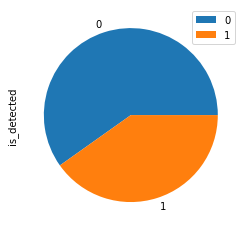

In [171]:
ratios.plot.pie()
plt.legend()

In [172]:
vid_length = get_length(vid_file)
vid_length

7.834

In [173]:
# distance moved
distance = df.x.max() - df.x.min()
distance

2.1672432260288854

In [174]:
# velocity in m/s
distance/vid_length

0.27664580367997005

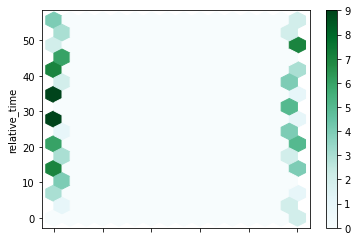

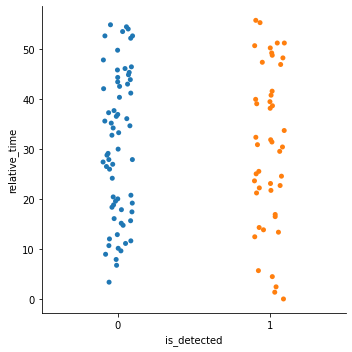

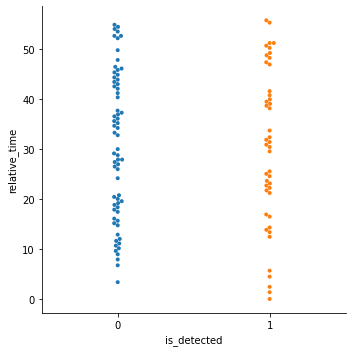

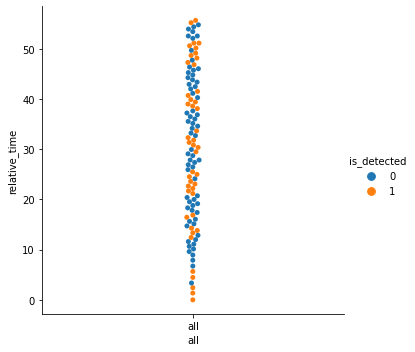

In [175]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")